# DNIKit Familiarity: Dataset Errors and Rare Samples

Using DNIKit [Familiarity](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.Familiarity), discover the least and most representative data samples in an overall dataset or within a data subgroup in order to understand dataset bias, spot outliers, and find dataset errors.

In [1]:
from dnikit.exceptions import enable_deprecation_warnings

enable_deprecation_warnings(error=True)  # treat DNIKit deprecation warnings as errors

## Set-up a DNIKit model that is able to run inference

Please see the docs for a breakdown of how to [load a model](https://apple.github.io/dnikit/how_to/connect_model.html) using DNIKit. This notebook uses DNIKit's [TFModelExamples](https://apple.github.io/dnikit/api/dnikit_tensorflow/index.html#dnikit_tensorflow.TFModelExamples) to load the MobileNet model directly.

In [2]:
from dnikit_tensorflow import TFModelExamples

# Load CIFAR10 dataset and feed into MobileNet,
# observing responses from layer conv_pw_13
mobilenet = TFModelExamples.MobileNet()

2023-08-03 12:41:23.728709: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-03 12:41:23.728735: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-08-03 12:41:23.728738: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-08-03 12:41:23.728771: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-03 12:41:23.728785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


/private/tmp/dnikit-2.0.0/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Create a DNI Dataset wrapping CIFAR-10
Download the CIFAR-10 dataset and create 2 sub-datasets to illustrate the familiarity concept.

* **datasets["cars"]:** Will contain 300 images of automobiles from the training set.
* **datasets["mixed"]:** Will contain 300 images randomly sampled across all classes in the test set.

Wrap the data into a DNIKit [Producer](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.Producer) in order to use CIFAR-10 in DNIKit. This example uses DNIKit's [TFDatasetExamples](https://apple.github.io/dnikit/api/dnikit_tensorflow/index.html#dnikit_tensorflow.TFDatasetExamples) to grab a built-in CIFAR-10 Producer. For defining a custom dataset, please see the docs for more information about how to [load data](https://apple.github.io/dnikit/how_to/connect_data.html) into DNIKit. This might include implementing a custom [Producer](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.Producer) or using another built-in Producer (e.g. [ImageProducer](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.ImageProducer) to load images from disk).

Moreover, MobileNet accepts images of size `224x224`, so it's necessary to pre-process the CIFAR-10 images by resizing them from `32x32` to `224x224`. DNIKit provides a set of processors in the module `dnikit.processors`. Here, [ImageResizer](https://apple.github.io/dnikit/api/dnikit/processors.html#dnikit.processors.ImageResizer) is used in a [pipeline](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.pipeline) that applies such pre-processing on top of CIFAR-10.

In [3]:
from dnikit.processors import ImageResizer, SnapshotSaver
from dnikit.base import Batch, PixelFormat, pipeline, ImageFormat
from dnikit_tensorflow import TFDatasetExamples

# Load CIFAR-10 with train and test datasets, and
# attach metadata (labels, dataset origins, image filepaths) to each batch
cifar10 = TFDatasetExamples.CIFAR10(attach_metadata=True)

mobilenet_preprocessor = mobilenet.preprocessing
assert mobilenet_preprocessor is not None

# Create pre-processing pipeline
preprocessing_stages = (
    # Save a snapshot of the raw image data to refer back to later
    SnapshotSaver(),

    # Preprocess the image batches in the manner expected by MobileNet
    mobilenet_preprocessor,
    
    # Resize images to fit the input of MobileNet, (224, 224) using an ImageResizer
    ImageResizer(pixel_format=ImageFormat.HWC, size=(224, 224)),
)

# Create producers for subsets of the dataset
datasets = dict()

# Create producer with just 300 samples of automobiles
# :: Note: The subset method will filter the batch LABELS metadata matching the provided dict
datasets["cars"] = cifar10.subset(labels=["automobile"], datasets=["train"], max_samples=300)

# Create producer with 300 random samples from all other classes in the test set
# :: Note: Pull from the test set to ensure no overlap with the "cars" subset
non_car_labels = [name for name in cifar10.str_to_label_idx() if name != "automobile"]
datasets["mixed"] = cifar10.subset(labels=non_car_labels, datasets=["test"], max_samples=300)
datasets["mixed"].shuffle()  # shuffle data samples

## 2. Run inference to obtain responses

This is a very important step in DNIKit. Define how responses are being pulled from the model as data is being fed. Also define how responses are post-processed so they have the dimensionality that suits the task.

For that, a dictionary of [Producers](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.Producer) is created from the dataset plus a processing/inference pipeline. In this example, a [Pooler](https://apple.github.io/dnikit/api/dnikit/processors.html#dnikit.processors.Pooler) is used to post-process the data.

*For more details about this step please check [the PFA Basic CNN Example Notebook](../model_introspection/principal_filter_analysis.ipynb), which contains a graphical explanation of this step.*

In [4]:
from dnikit.processors import Pooler

# convert the datasets (t.Mapping[str, Producer]) into a new t.Mapping[str, Producer]
# describing the processing pipeline.  Remember, the Producer is a promise for data,
# not the result of processing.
producers = {}
for dataset_name, dataset in datasets.items():
    producers[dataset_name] = pipeline(
        # Source of data -- this is either datasets["cars"] or datasets["mixed"]
        dataset,

        # Unwrap preprocessing into the pipeline
        *preprocessing_stages,

        # Run inference -- pass a list of requested responses or a single string
        mobilenet.model('conv_pw_13'),

        # Perform spatial max pooling on the result
        # For max pooling, use `method=Pooler.Method.MAX`,
        Pooler(dim=(1, 2), method=Pooler.Method.AVERAGE),
    )

### 2.1 Reduce the dimensionality using Principal Component Analysis (PCA)

The responses created earlier will be of dimension 1024 per image. This seems too high for CIFAR images. Remember that the MobileNet model used was trained for Imagenet.

DNIKit contains a [DimensionReduction](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.introspectors.DimensionReduction) Introspector that can help us reduce the dimensionality of the model's responses. In this case, use the [PCA](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.introspectors.DimensionReduction.Strategy.PCA) strategy to fit a PCA model on the automobile data, and then use it in a [pipeline](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.pipeline) to project all the responses to a length of 40.

In [5]:
from dnikit.introspectors import DimensionReduction

# Configure the DimensionReduction Introspector that will be used to reduce the dimensionality of the data from 1024 to 40
n_dim = 40

# fit the PCA model on the cars
print(f'Fitting PCA to {n_dim} dimensions, might take some seconds or minutes ...')
pca = DimensionReduction.introspect(producers["cars"], strategies=DimensionReduction.Strategy.PCA(n_dim))
print('Done.')

# the PCA object is another `PipelineStage` that can be used to transform batches to
# lower dimension data.  Convert the producers (t.Mapping[str, Producer]) into
# a new dictionary with each of those Producers dimension-reduced via the pca object.
reduced_producers = {
    # compose producers[name] with pca
    name: pipeline(producer, pca)
    for name, producer in producers.items()
}

Fitting PCA to 40 dimensions, might take some seconds or minutes ...


Done.


## 3. Fit familiarity model

Fit a gaussian mixture model in high dimensional space (obtained after PCA) on the 🚗 dataset. The model will capture the dense areas of the dataset, called *familiar*.

Using the fitted model, *score* the images of a dataset as being familiar or not to cars 🚗: call this `fam(data | 🚗)`.

* `fam(🚗 | 🚗)`: The most common cars in the dataset are expected to have high familiarity. The cars with low familiarity are those that are not well represented in the dataset (typically corner cases, strange viewpoints, etc).

* `fam(mixed | 🚗)`: The mixed dataset will likely have a few cars, expected to have high familiarity. Also the images of the "truck" class will probably have high familiarity with cars. On the other hand, images of forest and animals will probably have lower familiarity.

Familiarity can be used to spot corner cases and wrong annotations quickly!

In [6]:
from dnikit.introspectors import Familiarity

# Fit the familiarity model on the dimension reduced automobile 🚗 class of images
print('Fitting Familiarity, might take some seconds or minutes ...')

# Use the Familiarity.Strategy.GMM strategy by default
familiarity = Familiarity.introspect(reduced_producers["cars"])

# the familiarity object is something that can score responses (per layer) according to the model that was just
# trained.  it puts these scores (density) into metadata attached to the batch.  a higher score means
# more familiar and a lower score means less familiar.

print('Done fitting Familiarity.')

# Define how to score the 🚗 and mixed datasets according to the 🚗 familiarity model.
#
# now score the cars and mixed (dimension reduced) datasets with respect to
# the familiarity model that was just computed.  Use reduced_producers (t.Mapping[str, Producer])
# and compose it with familiarity to produce a new scored_producers.
scored_producers = {
    # compose reduced_producers[name] with familiarity
    name: pipeline(producer, familiarity)
    for name, producer in reduced_producers.items()
}

Fitting Familiarity, might take some seconds or minutes ...


Done fitting Familiarity.


## 4. Visualization

Once the density scores are computed, there are different ways to visualize them.  One way would be to use the [DatasetReport](https://apple.github.io/dnikit/introspectors/data_introspection/dataset_report.html)'s recommended way: with [Symphony](https://github.com/apple/ml-symphony).

For this notebook, define a simple class to hold the image data and the density score, that can bee sorted and displayed using matplotlib.

In [7]:
import dataclasses
import matplotlib.pyplot as plt
import numpy as np
import typing as t

from dnikit.base import Producer

@dataclasses.dataclass(frozen=True, order=True)
class FamiliarityResult:
    """Class to encapsulate the familiarity data and image."""
    density_score: float
    img: np.ndarray = dataclasses.field(compare=False)

    def plot(self, index: int, axarr: plt.Axes, color: str = 'b') -> None:
        """Add the image and score to the axes of a plot"""
        axarr[0, index].imshow(self.img)
        plt.setp(axarr[0, index].spines.values(), color=color)
        axarr[0, index].yaxis.set_major_locator(plt.NullLocator())
        axarr[0, index].xaxis.set_major_locator(plt.NullLocator())
        axarr[0, index].set_title(f'{self.density_score:0.3f}')

    @staticmethod
    def build(producer: Producer) -> t.Sequence["FamiliarityResult"]:
        """Construct a list of FamiliarityResult from a Producer"""
        return [
            FamiliarityResult(
                # pull the original raster data from the input attached to the snapshot
                img=batch.snapshots["snapshot"].fields["samples"][index],

                # and the scores are attached to the Familiarity.DENSITY_KEY metadata on the output field
                density_score=batch.metadata[familiarity.meta_key]["conv_pw_13"][index].score
                )
            for batch in producer(10)
            for index in range(batch.batch_size)
        ]

# produced sorted results in descending order -- note that this is actually evaluating the producers
# in the call to build()
print('Scoring and sorting data. This may take several seconds...')
sorted_automobile = sorted(FamiliarityResult.build(scored_producers["cars"]), reverse=True)
sorted_mixed = sorted(FamiliarityResult.build(scored_producers["mixed"]), reverse=True)
print('Done.')

Scoring and sorting data. This may take several seconds...


Done.


Show the top-10 and bottom-10 familiar images with respect to the 🚗 familiarity model.

* See how the least familiar cars are "less canonical" than the most familiar ones. This may indicate that more cars like these ones should be collected to enforce diversity.
* Check how the most familiar images from the mixed dataset are mostly cars and trucks. On the other hand, the leas familiar ones are mostly animals.
* There is a car in the least familiar mixed images. However, that car has a tilted viewpoint, which makes it less familiar.

fam(🚗 | 🚗)

Automobile most familiar


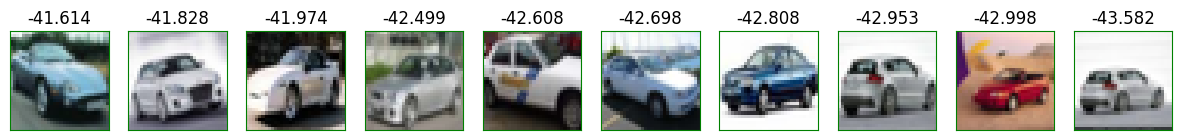

Automobile least familiar


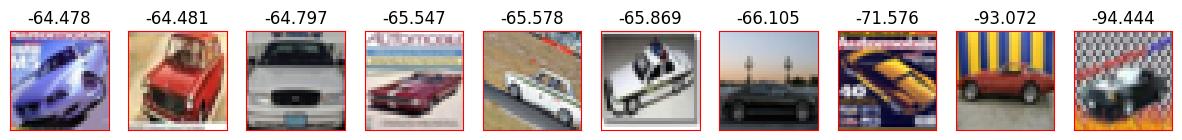

fam(mixed | 🚗)

Mixed most familiar


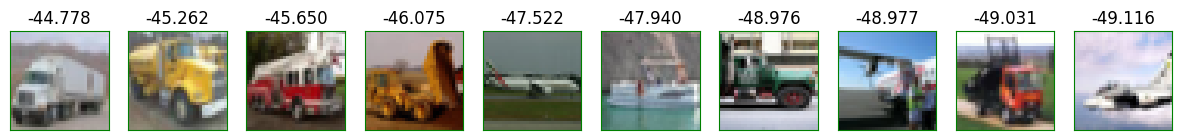

Mixed least familiar


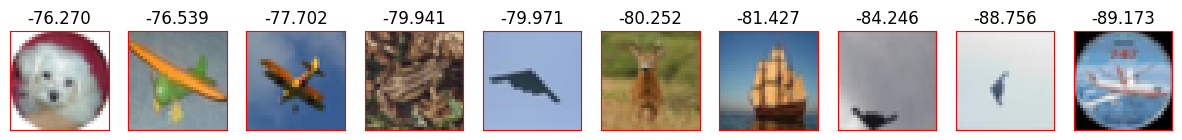

In [8]:
def show_results(results: t.Sequence[FamiliarityResult], title: str = '', color: str = 'b') -> None:
    print(title)
    _, axarr = plt.subplots(1, len(results), squeeze=False, figsize=(15,6))
    for index, result in enumerate(results):
        result.plot(index, axarr, color)
    plt.show()

print('==================\nfam(🚗 | 🚗)\n==================\n')
show_results(sorted_automobile[:10], title='Automobile most familiar', color='green')
show_results(sorted_automobile[-10:], title='Automobile least familiar', color='red')

print('==================\nfam(mixed | 🚗)\n==================\n')
show_results(sorted_mixed[:10], title='Mixed most familiar', color='green')
show_results(sorted_mixed[-10:], title='Mixed least familiar', color='red')
